# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [20]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [21]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator (Use if you don't have data ready)

In [22]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [23]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['rolling_std_5'] = df['ret'].rolling(5).std().shift(1)
df['rolling_min_5'] = df['price'].rolling(5).min().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,rolling_std_5,rolling_min_5,y_next_ret,y_up
2021-01-08,101.063685,0.000321,0.000321,-0.007561,-0.001379,0.004642,101.031283,0.000291,1
2021-01-11,101.093108,0.000291,0.000291,0.000321,-0.001315,0.004668,101.031283,-0.017099,0
2021-01-12,99.364481,-0.017099,-0.017247,0.000291,-0.000387,0.004365,101.031283,0.010532,1
2021-01-13,100.410953,0.010532,0.010477,-0.017099,-0.003933,0.008539,99.364481,0.006325,1
2021-01-14,101.046042,0.006325,0.006305,0.010532,-0.002703,0.010297,99.364481,-0.005937,0


## Split

In [24]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','rolling_std_5', 'rolling_min_5']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [25]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
mse = mean_squared_error(y_te_reg, pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.014518505973970593


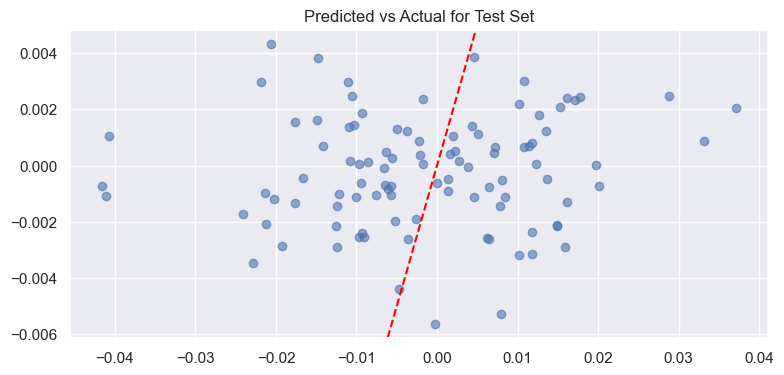

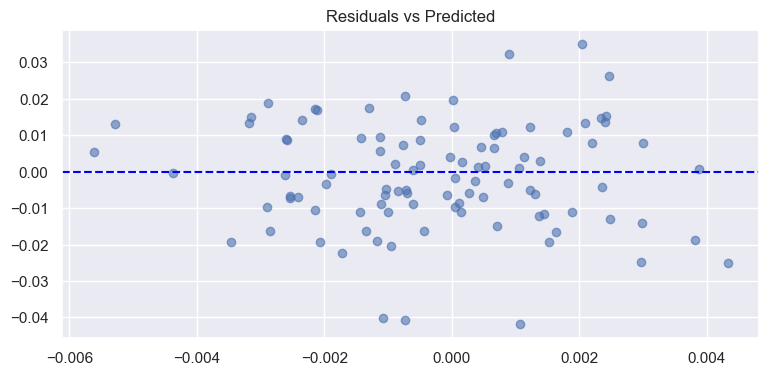

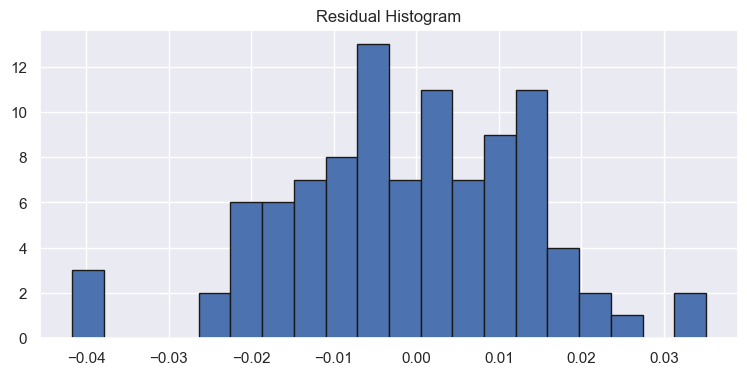

In [27]:
#Diagnostics
plt.figure()
plt.scatter(y_te_reg, pred, alpha=0.6)
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.title('Predicted vs Actual for Test Set')
plt.show()

resid = y_te_reg - pred
# Residuals vs Fitted
plt.figure()
plt.scatter(pred, resid, alpha=0.6)
plt.axhline(0, color='blue', linestyle='--')
plt.title('Residuals vs Predicted')
plt.show()
# Residual distribution
plt.figure()
plt.hist(resid, bins=20, edgecolor='k')
plt.title('Residual Histogram')
plt.show()

## Interpretation (Markdown)
- My model works because on the graph Predicted vs Actual for Test Set, the points clusters around the 45° line.
- The normality assumption might fail because the residual histogram is not bell-shaped.
- I might add more longer rolling statistics like rolling_mean_20_days.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.